In [60]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Dec 6, 2018
%matplotlib notebook

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os, fnmatch
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
import json
from PIL import Image as pil_image
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from NeMO_models import FCN
from NeMO_losses import charbonnierLoss 
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook
cloudmodel = load_model('./tmp/RefineMask_Cloud.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

In [98]:
path = '/home/shared/NeMO-Net Data/Sentinel/Mago/'
# imgpath = '/home/shared/NeMO-Net Data/Sentinel/Cicia/STL_4band_2016-02-29.tif'
# cldpath = '/home/shared/NeMO-Net Data/Sentinel/Cicia/STL_Cloud_2016-02-29.tif'
# cloudimg = cv2.imread(cldpath)
jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

files = os.listdir(path)
pattern = "STL_4band_*"
cloudless_files = []

# Initiate cloud cover calculation
nx = 3
ny = 3
xstart = 0
xlen = 256*nx
ystart = 0
ylen = 256*ny

def classifyback(predictions):
    return np.argmax(predictions,-1)

pixel_mean = 1800
pixel_std = 1800

for f in sorted(files):
    if fnmatch.fnmatch(f, pattern):
        try:
            print("Currently on: " + f, end='\r')
            imgpath = path + f
            Fiji_Sentinel = coralutils.CoralData(imgpath, load_type="raster")

            patch_R = 255/3000*Fiji_Sentinel.image[:,:,0]
            patch_G = 255/3000*Fiji_Sentinel.image[:,:,1]
            patch_B = 255/3000*Fiji_Sentinel.image[:,:,2]
            patch_R[patch_R > 255] = 255
            patch_G[patch_G > 255] = 255
            patch_B[patch_B > 255] = 255
            Fiji_Sentinel_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)

            predict_img = np.zeros((ylen,xlen))
            for i in range(nx):
                for j in range(ny):
                    testimg = Fiji_Sentinel.image[ystart+j*256:ystart+j*256+256,xstart+i*256:xstart+i*256+256,:]
                    testimg = img_to_array(testimg, data_format=K.image_data_format())
                    testimg = (testimg-pixel_mean)/pixel_std
                    imgbatch = np.expand_dims(testimg, axis=0)
                    imgpredict = cloudmodel.predict(imgbatch, batch_size = 1)[0]
                    imgpredict = np.reshape(classifyback(imgpredict), (256,256))
                    predict_img[j*256:j*256+256,i*256:i*256+256] = imgpredict

            perc_cloud = np.sum(predict_img == 1.)/(predict_img.shape[0]*predict_img.shape[1])*100
            if perc_cloud < 5:
                cloudless_files.append(f)
        except:
            print("Error in evaluation, skipping this day...", f)


print(cloudless_files)

['STL_4band_2016-04-09.tif', 'STL_4band_2016-04-29.tif', 'STL_4band_2016-05-16.tif', 'STL_4band_2016-05-29.tif', 'STL_4band_2016-07-08.tif', 'STL_4band_2016-08-24.tif', 'STL_4band_2016-09-26.tif', 'STL_4band_2016-11-22.tif', 'STL_4band_2017-01-14.tif', 'STL_4band_2017-04-04.tif', 'STL_4band_2017-06-23.tif', 'STL_4band_2017-08-04.tif', 'STL_4band_2017-08-17.tif', 'STL_4band_2017-08-27.tif', 'STL_4band_2017-09-01.tif', 'STL_4band_2017-09-21.tif', 'STL_4band_2017-09-28.tif', 'STL_4band_2017-12-17.tif']


(884, 855, 4)
(884, 855, 4)


<IPython.core.display.Javascript object>


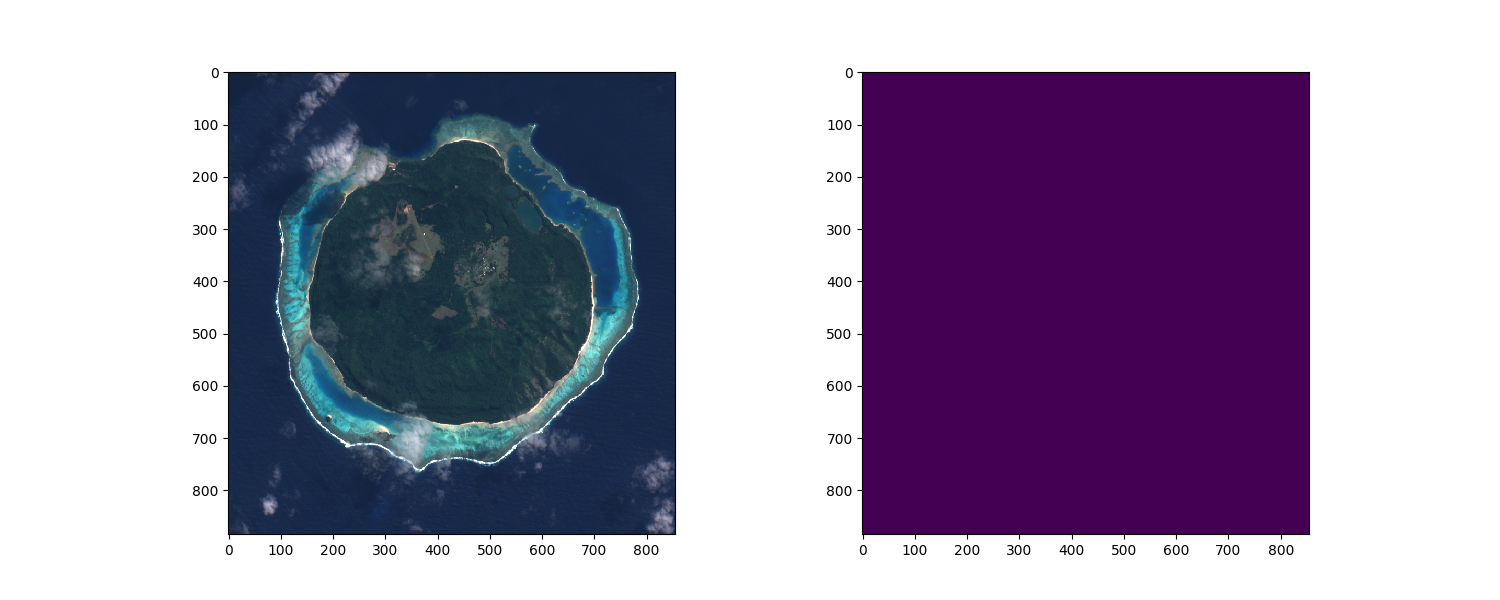

<IPython.core.display.Javascript object>


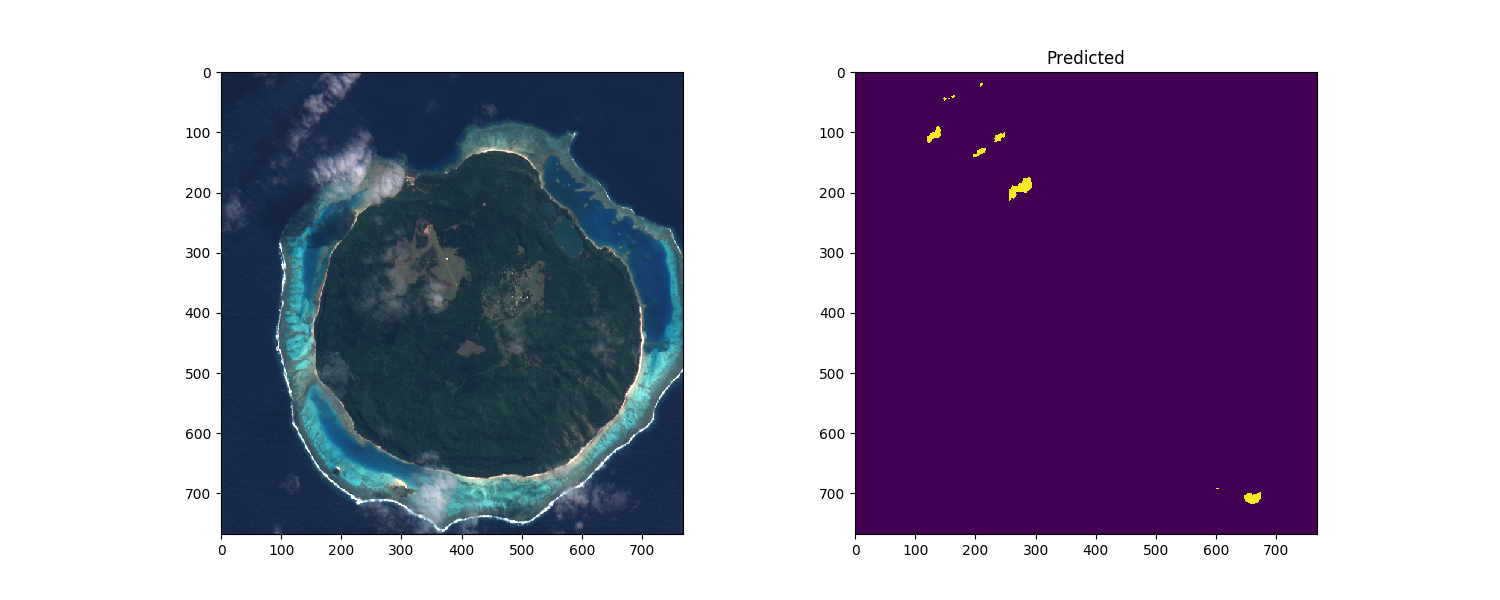

0.31382242838541663


In [101]:
imgpath = '/home/shared/NeMO-Net Data/Sentinel/Mago/STL_4band_2017-08-17.tif'
cldpath = '/home/shared/NeMO-Net Data/Sentinel/Mago/STL_Cloud_2017-08-17.tif'
cloudimg = cv2.imread(cldpath)
jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

Fiji_Sentinel = coralutils.CoralData(imgpath, load_type="raster")
print(Fiji_Sentinel.image.shape)

patch_R = 255/3000*Fiji_Sentinel.image[:,:,0]
patch_G = 255/3000*Fiji_Sentinel.image[:,:,1]
patch_B = 255/3000*Fiji_Sentinel.image[:,:,2]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_Sentinel_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
print(Fiji_Sentinel.image.shape)

fig = plt.figure(1,figsize=(15,6))
ax = plt.subplot(121)
plt.imshow(Fiji_Sentinel_RGB)

ax = plt.subplot(122)
ax.imshow(cloudimg[:,:,0])

# Initiate cloud cover calculation
nx = 3
ny = 3
xstart = 0
xlen = 256*nx
ystart = 0
ylen = 256*ny

def classifyback(predictions):
    return np.argmax(predictions,-1)

pixel_mean = 1800
pixel_std = 1800

predict_img = np.zeros((ylen,xlen))
for i in range(nx):
    for j in range(ny):
        testimg = Fiji_Sentinel.image[ystart+j*256:ystart+j*256+256,xstart+i*256:xstart+i*256+256,:]
        testimg = img_to_array(testimg, data_format=K.image_data_format())
        testimg = (testimg-pixel_mean)/pixel_std
        imgbatch = np.expand_dims(testimg, axis=0)
        imgpredict = cloudmodel.predict(imgbatch, batch_size = 1)[0]
        imgpredict = np.reshape(classifyback(imgpredict), (256,256))
        predict_img[j*256:j*256+256,i*256:i*256+256] = imgpredict

fig = plt.figure(2, figsize=(15,6))
ax = plt.subplot(121)
ax.imshow(Fiji_Sentinel_RGB[ystart:ystart+ylen,xstart:xstart+xlen,0:3])

ax = plt.subplot(122)
ax.imshow(predict_img)
ax.set_title("Predicted")
plt.show()

perc_cloud = np.sum(predict_img == 1.)/(predict_img.shape[0]*predict_img.shape[1])
print(perc_cloud*100)


(884, 855, 4)
(884, 855, 4)


<IPython.core.display.Javascript object>


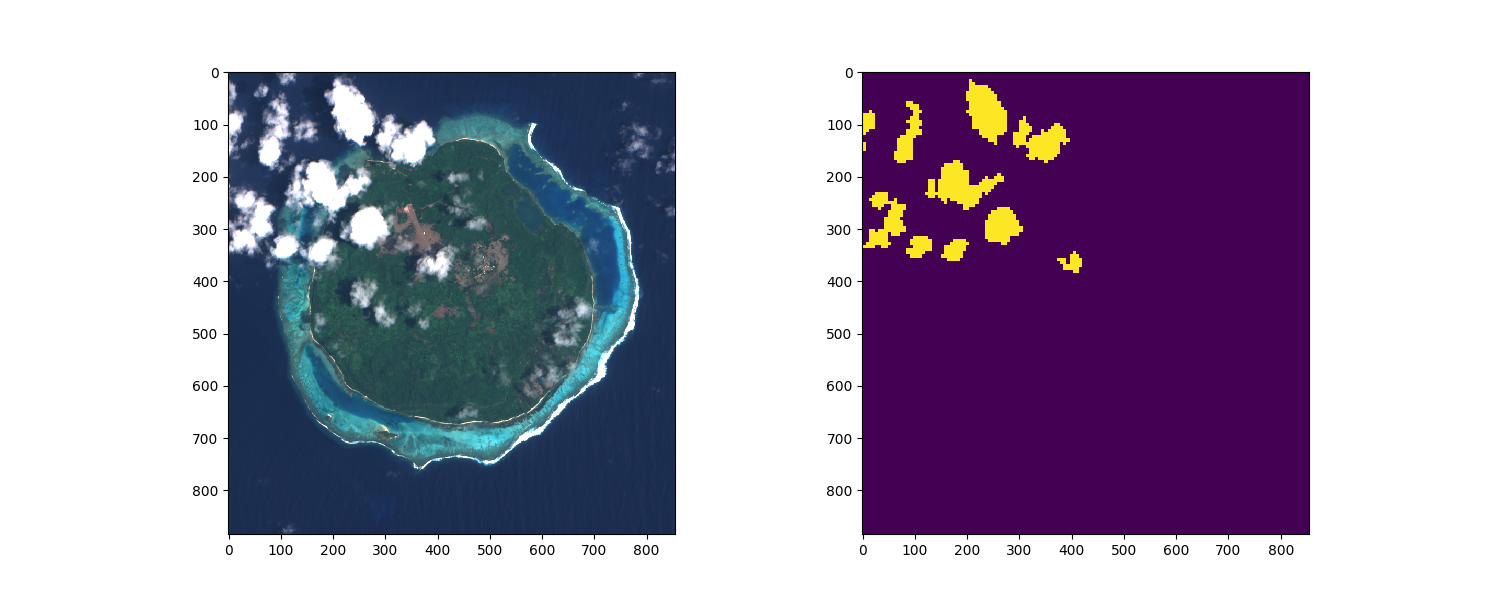

In [97]:
imgpath = '/home/shared/NeMO-Net Data/Sentinel/Mago/STL_4band_2016-01-17.tif'
cldpath = '/home/shared/NeMO-Net Data/Sentinel/Mago/STL_Cloud_2016-01-17.tif'
cloudimg = cv2.imread(cldpath)
jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

Fiji_Sentinel = coralutils.CoralData(imgpath, load_type="raster")
print(Fiji_Sentinel.image.shape)

patch_R = 255/3000*Fiji_Sentinel.image[:,:,0]
patch_G = 255/3000*Fiji_Sentinel.image[:,:,1]
patch_B = 255/3000*Fiji_Sentinel.image[:,:,2]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_Sentinel_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
print(Fiji_Sentinel.image.shape)

fig = plt.figure(3,figsize=(15,6))
ax = plt.subplot(121)
plt.imshow(Fiji_Sentinel_RGB)

ax = plt.subplot(122)
ax.imshow(cloudimg[:,:,0])